<a href="https://colab.research.google.com/github/Renad87/Graduation-Project1/blob/main/ms_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
!unzip MS_Detection_Project.zip -d .


Archive:  MS_Detection_Project.zip
   creating: ./MS_Detection_Project/data/
   creating: ./MS_Detection_Project/reports/
 extracting: ./MS_Detection_Project/app/gradio_app.py  
   creating: ./MS_Detection_Project/data/processed/
   creating: ./MS_Detection_Project/data/raw/
   creating: ./MS_Detection_Project/data/splits/
 extracting: ./MS_Detection_Project/models/cnn_lstm_model.py  
 extracting: ./MS_Detection_Project/models/utils.py  
 extracting: ./MS_Detection_Project/notebooks/01_data_exploration.ipynb  
 extracting: ./MS_Detection_Project/notebooks/02_preprocessing.ipynb  
 extracting: ./MS_Detection_Project/notebooks/03_training_CNN_LSTM.ipynb  
 extracting: ./MS_Detection_Project/notebooks/04_evaluation.ipynb  
 extracting: ./MS_Detection_Project/notebooks/05_gradio_UI.ipynb  
   creating: ./MS_Detection_Project/reports/graphs/
   creating: ./MS_Detection_Project/reports/training_logs/
 extracting: ./MS_Detection_Project/data/splits/test/ms.py  
 extracting: ./MS_Detection_Pro

In [ ]:
import os
#الداتا الاولى
os.environ['KAGGLE_USERNAME'] = "RENAD"
os.environ['KAGGLE_KEY'] = "KGAT_63c0a3f51a214a4d6657fc9b7143f0ff"

!kaggle datasets download -d thebrownkid/paired-mri-t1-t2
!unzip -q paired-mri-t1-t2.zip -d dataset
print("تم التحميل وفك الضغط بنجاح!")
import os, cv2, random

BASE = "dataset/MRI_T1_T2_DATASET"
cat = random.choice(["t1","t2"])
folder = os.path.join(BASE, cat)
f = random.choice([x for x in os.listdir(folder) if x.lower().endswith((".png",".jpg",".jpeg"))])
img = cv2.imread(os.path.join(folder,f), cv2.IMREAD_GRAYSCALE)
print("Category:", cat, "File:", f, "Shape:", img.shape)

Dataset URL: https://www.kaggle.com/datasets/thebrownkid/paired-mri-t1-t2
License(s): CC-BY-SA-4.0
  0% 0.00/87.3M [00:00<?, ?B/s]
100% 87.3M/87.3M [00:00<00:00, 1.34GB/s]
تم التحميل وفك الضغط بنجاح!
Category: t2 File: image20.00110.jpg Shape: (384, 354)


In [ ]:
import os
#الداتا الثانية
os.environ['KAGGLE_USERNAME'] = "RENAD"
os.environ['KAGGLE_KEY'] = "KGAT_63c0a3f51a214a4d6657fc9b7143f0ff"

!kaggle datasets download -d trainingdatapro/dicom-brain-dataset
!unzip -q dicom-brain-dataset.zip -d dataset
print("✅ تم تحميل وفك ضغط DICOM Brain Dataset بنجاح")

Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/dicom-brain-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
  0% 0.00/72.8M [00:00<?, ?B/s]
100% 72.8M/72.8M [00:00<00:00, 1.12GB/s]
✅ تم تحميل وفك ضغط DICOM Brain Dataset بنجاح


In [ ]:
import os
#الداتا الثالثة
os.environ['KAGGLE_USERNAME'] = "RENAD"
os.environ['KAGGLE_KEY'] = "KGAT_63c0a3f51a214a4d6657fc9b7143f0ff"

!kaggle datasets download -d trainingdatapro/multiple-sclerosis-dataset
!unzip -q multiple-sclerosis-dataset.zip -d datasett
print("✅ تم تحميل وفك ضغط DICOM Brain Dataset بنجاح")

Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/multiple-sclerosis-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
multiple-sclerosis-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
✅ تم تحميل وفك ضغط DICOM Brain Dataset بنجاح


In [ ]:
import os, cv2, torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

BASE_DATA_PATH = 'dataset/MRI_T1_T2_DATASET_PROCESSED'
IMG_SIZE = 224          # ✅ لازم 224 عشان 56×56 بعد pooling
BATCH_SIZE = 8

class MRIDatasetForCNNLSTM(Dataset):
    def __init__(self, base_path):
        self.samples = []
        self.labels = {'t1': 0, 't2': 1}

        for name, label in self.labels.items():
            folder = os.path.join(base_path, name)
            for f in os.listdir(folder):
                if f.lower().endswith(('.jpg','.png','.jpeg')):
                    self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0                      # [H,W] float
        img = torch.from_numpy(img).unsqueeze(0)                  # [1,H,W]
        img = img.unsqueeze(0)                                    # ✅ [seq=1, 1, H, W]

        y = torch.tensor([label], dtype=torch.float32)            # ✅ [1] عشان BCELoss
        return img, y

dataset = MRIDatasetForCNNLSTM(BASE_DATA_PATH)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# اختبار شكل الداتا:
x, y = next(iter(loader))
print("x:", x.shape)  # لازم: [B, 1, 1, 224, 224]
print("y:", y.shape)  # [B, 1]


x: torch.Size([8, 1, 1, 224, 224])
y: torch.Size([8, 1])


In [ ]:
import os, cv2, torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

BASE_DATA_PATH = 'dataset/MRI_T1_T2_DATASET_PROCESSED'
IMG_SIZE = 354
BATCH_SIZE = 8

class MRIDataset(Dataset):
    def __init__(self, base_path):
        self.samples = []
        self.labels = {'t1': 0, 't2': 1}

        for name, label in self.labels.items():
            folder = os.path.join(base_path, name)
            for f in os.listdir(folder):
                if f.lower().endswith(('.jpg','.png','.jpeg')):
                    self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0

        img = torch.from_numpy(img).unsqueeze(0)   # [1,H,W]
        img = img.unsqueeze(0)                     # [seq=1,1,H,W]

        y = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return img, y


In [ ]:
dataset = MRIDataset(BASE_DATA_PATH)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# اختبار سريع (مهم)
x, y = next(iter(loader))
print(x.shape)   # لازم: [B, 1, 1, 354, 354]
print(y.shape)   # [B, 1]


torch.Size([8, 1, 1, 354, 354])
torch.Size([8, 1])


In [ ]:

import torch
import torch.nn as nn
# موديل التدريب
class CNN_LSTM_Model(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Model, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(2))

        self.flatten = nn.Flatten()

        self.lstm = nn.LSTM(
            input_size=256 * 88 * 88, # Corrected input_size based on 354x354 input images
            hidden_size=256,
            num_layers=1,
            batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1),
            nn.Sigmoid() )

    def forward(self, x):
        batch, seq, c, h, w = x.size()

        cnn_features = []
        for i in range(seq):
            out = self.cnn(x[:, i, :, :, :])
            out = self.flatten(out)
            cnn_features.append(out)

        cnn_features = torch.stack(cnn_features, dim=1)

        lstm_out, _ = self.lstm(cnn_features)

        final_output = lstm_out[:, -1, :]

        out = self.fc(final_output)

        return out

In [ ]:
import os, cv2, torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

BASE_DATA_PATH = 'dataset/MRI_T1_T2_DATASET_PROCESSED'
IMG_SIZE = 354
BATCH_SIZE = 8

class MRIDataset(Dataset):
    def __init__(self, base_path):
        self.samples = []
        self.labels = {'t1': 0, 't2': 1}

        for name, label in self.labels.items():
            folder = os.path.join(base_path, name)
            for f in os.listdir(folder):
                if f.lower().endswith(('.jpg','.png','.jpeg')):
                    self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.0      # [0,1]
        img = torch.from_numpy(img).unsqueeze(0)  # [1,H,W]

        return img, torch.tensor(label)

dataset = MRIDataset(BASE_DATA_PATH)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# اختبار سريع
x, y = next(iter(loader))
print(x.shape)  # [B,1,354,354]
print(y.shape)  # [B]

torch.Size([8, 1, 354, 354])
torch.Size([8])


Processing & Saving t1:   0%|          | 0/3463 [00:00<?, ?it/s]

Processing & Saving t2:   0%|          | 0/3463 [00:00<?, ?it/s]


✅ انتهت معالجة وحفظ جميع الصور
📦 Total found: 6926
💾 Saved: 6926
📁 Output: dataset/MRI_T1_T2_DATASET_PROCESSED


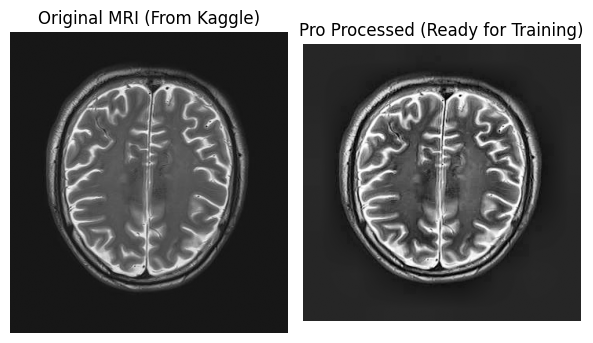

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
from skimage.restoration import denoise_wavelet
# معالجة الداتا الاولى

BASE_DATA_PATH = 'dataset/MRI_T1_T2_DATASET'
IMG_SIZE = 354


def preprocess_pro_mri(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # Convert to [1,0]
    img_float = img.astype(np.float32) / 255.0

    # noise removal
    img_denoised = denoise_wavelet(img_float, method='BayesShrink', mode='soft', rescale_sigma=True)

    # Improve Contrast
    img_8bit = (img_denoised * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_8bit)

    # (Unsharp Masking)
    gaussian_3 = cv2.GaussianBlur(img_enhanced, (0, 0), 2.0)
    img_final = cv2.addWeighted(img_enhanced, 1.35, gaussian_3, -0.35, 0)
    img_final= img_final.astype(np.float32)/255.0

    return img_final


def process_and_save_all(base_path):
    # processed_samples = [] # This variable is not used and can be removed.
    all_files = [] # This list will store paths of all processed images for random selection

    OUT_BASE_PATH = 'dataset/MRI_T1_T2_DATASET_PROCESSED'

    os.makedirs(OUT_BASE_PATH, exist_ok=True)

    categories = ['t1', 't2']
    total = 0
    saved = 0

    for cat in categories:
        cat_path = os.path.join(base_path, cat)
        out_cat_path = os.path.join(OUT_BASE_PATH, cat)
        os.makedirs(out_cat_path, exist_ok=True)

        if not os.path.exists(cat_path):
            print(f"⚠️ المجلد غير موجود: {cat_path}")
            continue

        files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        total += len(files)

        for f in tqdm(files, desc=f"Processing & Saving {cat}"):
            in_path = os.path.join(cat_path, f)
            all_files.append(in_path) # Add the path to the list for random selection
            img = preprocess_pro_mri(in_path)   # يرجع float [0,1]
            if img is None:
                continue

            # ✅ للحفظ على القرص لازم uint8 (0..255)
            img_u8 = (img * 255.0).clip(0, 255).astype(np.uint8)

            out_path = os.path.join(out_cat_path, f)  # نفس الاسم
            cv2.imwrite(out_path, img_u8)
            saved += 1

    print("\n" + "="*40)
    print("✅ انتهت معالجة وحفظ جميع الصور")
    print(f"📦 Total found: {total}")
    print(f"💾 Saved: {saved}")
    print(f"📁 Output: {OUT_BASE_PATH}")
    print("="*40)

    # Image selection and processing for display
    if not all_files:
        print("❌ No images were processed to select a random one for display.")
        return

    random_path = random.choice(all_files)
    original_img = cv2.imread(random_path, cv2.IMREAD_GRAYSCALE)
    processed_img = preprocess_pro_mri(random_path)

    # Check if processing of the random image was successful
    if original_img is None or processed_img is None:
        print(f"❌ Failed to load or preprocess the selected random sample: {random_path}")
        print("Skipping display for this sample.")
        return

    plt.figure(figsize=(6, 6))

    # View original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original MRI (From Kaggle)")
    plt.axis('off')

    # Image display after processing
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("Pro Processed (Ready for Training)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the random display
# process_and_show_random(BASE_DATA_PATH)
process_and_save_all(BASE_DATA_PATH)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.restoration import denoise_wavelet
# الداتا الثانية
# DICOM support
!pip install pydicom
import pydicom

BASE_DATA_PATH = 'dataset/ST000001'
IMG_SIZE = 256

# 1) Reading the image(PNG/JPG And DICOM)
def read_medical_image(path: str) -> np.ndarray | None:
    ext = os.path.splitext(path)[1].lower()

    # DICOM
    if ext == ".dcm":
        try:
            ds = pydicom.dcmread(path)
            img = ds.pixel_array.astype(np.float32)

            # Rescale slope/intercept
            slope = float(getattr(ds, "RescaleSlope", 1.0))
            intercept = float(getattr(ds, "RescaleIntercept", 0.0))
            img = img * slope + intercept


            # Robust normalization to [0,1] using percentiles
            p1, p99 = np.percentile(img, (1, 99))
            img = np.clip(img, p1, p99)
            img = (img - p1) / (p99 - p1 + 1e-8)


            # Convert to 8-bit for CLAHE
            img_8bit = (img * 255).astype(np.uint8)
            return img_8bit

        except Exception as e:
            print(f"❌ Failed to read DICOM file: {path}\nError reason: {e}")
            return None

    # PNG/JPG
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img



# 2) Preprocessing
def preprocess_pro_mri(image_path: str) -> np.ndarray | None:
    img = read_medical_image(image_path)
    if img is None:
        return None

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # transformation [1,0]
    img_float = img.astype(np.float32) / 255.0

    # Wavelet Denoising
    img_denoised = denoise_wavelet(
        img_float,
        method='BayesShrink',
        mode='soft',
        rescale_sigma=True)

    # CLAHE
    img_8bit = np.clip(img_denoised * 255.0, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_8bit)

    # Sharpen (Unsharp Masking)
    blurred = cv2.GaussianBlur(img_enhanced, (0, 0), 2.0)
    img_final = cv2.addWeighted(img_enhanced, 1.35, blurred, -0.35, 0)
    # img_final= img_final.astype(np.float32)/255.0

    return img_final



# 3) File collection and sample presentation (Recursive)
def collect_images_recursive(base_path: str, exts=('.jpg', '.jpeg', '.png', '.dcm')):
    all_files = ['SE000001', 'SE000002','SE000003','SE000004','SE000005','SE000006','SE000007']
    for root, _, files in os.walk(base_path):
        for f in files:
            if f.lower().endswith(exts):
                all_files.append(os.path.join(root, f))
    return all_files


def process_and_show_random(base_path: str):
    all_files = collect_images_recursive(base_path)

    if not all_files:
        print("❌ No image was found within the specified path")
        print("Please ensure that BASE_DATA_PATH contains DICOM (.dcm) files or image files.")
        return

    random_path = random.choice(all_files)
    original_img = read_medical_image(random_path)
    processed_img = preprocess_pro_mri(random_path)

    if original_img is None or processed_img is None:
        print("❌ Failed to load or preprocess the selected sample. Please rerun the function.")

        return

    print(f"✅ Selected file:\n{random_path}")


    plt.figure(figsize=(6, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original (Loaded Correctly)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("Processed (Ready for Training)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_and_save_all(base_path: str):
    OUT_BASE_PATH = base_path + "_PROCESSED"
    os.makedirs(OUT_BASE_PATH, exist_ok=True)

    all_files = collect_images_recursive(base_path)

    if not all_files:
        print("❌ No images found to process.")
        return

    total = 0
    saved = 0

    print("🚀 Starting preprocessing and saving all images...\n")

    for path in all_files:
        # تجاهل أي مدخل مو ملف صورة
        if not isinstance(path, str):
            continue

        processed_img = preprocess_pro_mri(path)
        if processed_img is None:
            continue

        # الحفاظ على البنية النسبية للمجلدات
        rel_path = os.path.relpath(path, base_path)
        rel_dir = os.path.dirname(rel_path)

        save_dir = os.path.join(OUT_BASE_PATH, rel_dir)
        os.makedirs(save_dir, exist_ok=True)

        # اسم الملف النهائي
        base_name = os.path.splitext(os.path.basename(path))[0]
        save_path = os.path.join(save_dir, base_name + ".png")

        cv2.imwrite(save_path, processed_img)

        total += 1
        saved += 1

    print("\n" + "=" * 45)
    print("✅ Preprocessing completed")
    print(f"📦 Total images processed: {total}")
    print(f"💾 Images saved: {saved}")
    print(f"📁 Output folder: {OUT_BASE_PATH}")
    print("=" * 45)



process_and_show_random(BASE_DATA_PATH)
process_and_save_all(BASE_DATA_PATH)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.0 MB/s eta 0:00:00
✅ Selected file:
datasett/ST000001/SE000011/IM000021.jpg


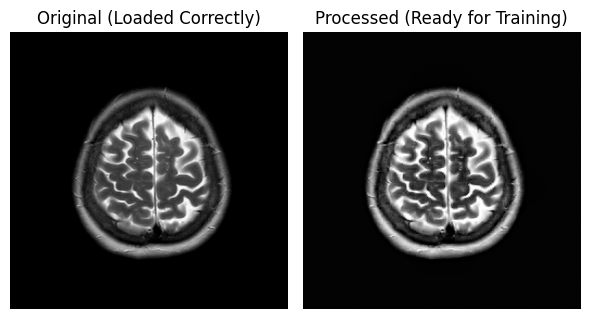

🚀 Starting preprocessing and saving all images...


✅ Preprocessing completed
📦 Total images processed: 762
💾 Images saved: 762
📁 Output folder: datasett/ST000001_PROCESSED


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.restoration import denoise_wavelet
# الداتا الثالثة
# DICOM support
!pip install pydicom
import pydicom

BASE_DATA_PATH = 'datasett/ST000001'
IMG_SIZE = 256

# 1) Reading the image(PNG/JPG And DICOM)
def read_medical_image(path: str) -> np.ndarray | None:
    ext = os.path.splitext(path)[1].lower()

    # DICOM
    if ext == ".dcm":
        try:
            ds = pydicom.dcmread(path)
            img = ds.pixel_array.astype(np.float32)

            # Rescale slope/intercept
            slope = float(getattr(ds, "RescaleSlope", 1.0))
            intercept = float(getattr(ds, "RescaleIntercept", 0.0))
            img = img * slope + intercept


            # Robust normalization to [0,1] using percentiles
            p1, p99 = np.percentile(img, (1, 99))
            img = np.clip(img, p1, p99)
            img = (img - p1) / (p99 - p1 + 1e-8)


            # Convert to 8-bit for CLAHE
            img_8bit = (img * 255).astype(np.uint8)
            return img_8bit

        except Exception as e:
            print(f"❌ Failed to read DICOM file: {path}\nError reason: {e}")
            return None

    # PNG/JPG
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img



# 2) Preprocessing
def preprocess_pro_mri(image_path: str) -> np.ndarray | None:
    img = read_medical_image(image_path)
    if img is None:
        return None

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # transformation [1,0]
    img_float = img.astype(np.float32) / 255.0

    # Wavelet Denoising
    img_denoised = denoise_wavelet(
        img_float,
        method='BayesShrink',
        mode='soft',
        rescale_sigma=True)

    # CLAHE
    img_8bit = np.clip(img_denoised * 255.0, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_8bit)

    # Sharpen (Unsharp Masking)
    blurred = cv2.GaussianBlur(img_enhanced, (0, 0), 2.0)
    img_final = cv2.addWeighted(img_enhanced, 1.35, blurred, -0.35, 0)
    # img_final= img_final.astype(np.float32)/255.0

    return img_final



# 3) File collection and sample presentation (Recursive)
def collect_images_recursive(base_path: str, exts=('.jpg', '.jpeg', '.png', '.dcm')):
    all_files = ['SE000001', 'SE000002','SE000003','SE000004','SE000005','SE000006','SE000007']
    for root, _, files in os.walk(base_path):
        for f in files:
            if f.lower().endswith(exts):
                all_files.append(os.path.join(root, f))
    return all_files


def process_and_show_random(base_path: str):
    all_files = collect_images_recursive(base_path)

    if not all_files:
        print("❌ No image was found within the specified path")
        print("Please ensure that BASE_DATA_PATH contains DICOM (.dcm) files or image files.")
        return

    random_path = random.choice(all_files)
    original_img = read_medical_image(random_path)
    processed_img = preprocess_pro_mri(random_path)

    if original_img is None or processed_img is None:
        print("❌ Failed to load or preprocess the selected sample. Please rerun the function.")

        return

    print(f"✅ Selected file:\n{random_path}")


    plt.figure(figsize=(6, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original (Loaded Correctly)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("Processed (Ready for Training)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_and_save_all(base_path: str):
    OUT_BASE_PATH = base_path + "_PROCESSED"
    os.makedirs(OUT_BASE_PATH, exist_ok=True)

    all_files = collect_images_recursive(base_path)

    if not all_files:
        print("❌ No images found to process.")
        return

    total = 0
    saved = 0

    print("🚀 Starting preprocessing and saving all images...\n")

    for path in all_files:
        # تجاهل أي مدخل مو ملف صورة
        if not isinstance(path, str):
            continue

        processed_img = preprocess_pro_mri(path)
        if processed_img is None:
            continue

        # الحفاظ على البنية النسبية للمجلدات
        rel_path = os.path.relpath(path, base_path)
        rel_dir = os.path.dirname(rel_path)

        save_dir = os.path.join(OUT_BASE_PATH, rel_dir)
        os.makedirs(save_dir, exist_ok=True)

        # اسم الملف النهائي
        base_name = os.path.splitext(os.path.basename(path))[0]
        save_path = os.path.join(save_dir, base_name + ".png")

        cv2.imwrite(save_path, processed_img)

        total += 1
        saved += 1

    print("\n" + "=" * 45)
    print("✅ Preprocessing completed")
    print(f"📦 Total images processed: {total}")
    print(f"💾 Images saved: {saved}")
    print(f"📁 Output folder: {OUT_BASE_PATH}")
    print("=" * 45)



process_and_show_random(BASE_DATA_PATH)
process_and_save_all(BASE_DATA_PATH)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
